# Thrones2Vec

## Imports

In [38]:
from __future__ import absolute_import, division, print_function

In [39]:
import gensim
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [40]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [41]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


e:\programs\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Set up logging**

In [42]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [43]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tony\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [44]:
book_filenames = sorted(glob.glob("data/*.txt"))

In [45]:
print("Found books:")
book_filenames

Found books:


['data\\got1.txt',
 'data\\got2.txt',
 'data\\got3.txt',
 'data\\got4.txt',
 'data\\got5.txt']

**Combine the books into one string**

In [46]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data\got1.txt'...
Corpus is now 1770659 characters long

Reading 'data\got2.txt'...
Corpus is now 4071041 characters long

Reading 'data\got3.txt'...
Corpus is now 6391405 characters long

Reading 'data\got4.txt'...
Corpus is now 8107945 characters long

Reading 'data\got5.txt'...
Corpus is now 9719485 characters long



**Split the corpus into sentences**

In [47]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [48]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [49]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [50]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [51]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [52]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


## Train Word2Vec

In [53]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [54]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [55]:
thrones2vec.build_vocab(sentences)

2019-01-31 18:16:34,708 : INFO : collecting all words and their counts
2019-01-31 18:16:34,709 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-31 18:16:34,751 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2019-01-31 18:16:34,792 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2019-01-31 18:16:34,831 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2019-01-31 18:16:34,869 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2019-01-31 18:16:34,909 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2019-01-31 18:16:34,951 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2019-01-31 18:16:34,995 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2019-01-31 18:16:35,038 : INFO : PROGRESS: at 

In [56]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


**Start training, this might take a minute or two...**

In [57]:
thrones2vec.train(total_examples=thrones2vec.corpus_count ,sentences = sentences, epochs = 10)

2019-01-31 18:16:35,919 : INFO : training model with 8 workers on 17277 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-01-31 18:16:36,932 : INFO : EPOCH 1 - PROGRESS: at 19.77% examples, 277304 words/s, in_qsize 15, out_qsize 0
2019-01-31 18:16:37,933 : INFO : EPOCH 1 - PROGRESS: at 43.96% examples, 300990 words/s, in_qsize 15, out_qsize 0
2019-01-31 18:16:38,934 : INFO : EPOCH 1 - PROGRESS: at 66.18% examples, 308663 words/s, in_qsize 15, out_qsize 0
2019-01-31 18:16:39,948 : INFO : EPOCH 1 - PROGRESS: at 89.47% examples, 309291 words/s, in_qsize 14, out_qsize 1
2019-01-31 18:16:40,274 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-31 18:16:40,283 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-31 18:16:40,319 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-31 18:16:40,325 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-01-31 18:16:40,341 : INFO

2019-01-31 18:17:05,429 : INFO : EPOCH 7 - PROGRESS: at 69.09% examples, 318684 words/s, in_qsize 15, out_qsize 0
2019-01-31 18:17:06,479 : INFO : EPOCH 7 - PROGRESS: at 92.42% examples, 315778 words/s, in_qsize 16, out_qsize 0
2019-01-31 18:17:06,679 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-31 18:17:06,691 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-31 18:17:06,714 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-31 18:17:06,720 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-01-31 18:17:06,732 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 18:17:06,741 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 18:17:06,756 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 18:17:06,778 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 18:17:06,780 : INFO : EPOCH - 7 :

(14043847, 18181030)

**Save to file, can be useful later**

In [58]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [59]:
thrones2vec.wv.save_word2vec_format(os.path.join("trained", "thrones2vec.w2v"))

2019-01-31 18:17:19,975 : INFO : storing 17277x300 projection weights into trained\thrones2vec.w2v


## Explore the trained model.

In [60]:
thrones2vec = gensim.models.KeyedVectors.load_word2vec_format(os.path.join("trained", "thrones2vec.w2v"))

2019-01-31 18:17:24,750 : INFO : loading projection weights from trained\thrones2vec.w2v
2019-01-31 18:17:30,779 : INFO : loaded (17277, 300) matrix from trained\thrones2vec.w2v


### Compress the word vectors into 2D space and plot them

In [61]:
#Dimentionality reduction with t-sne
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [62]:
all_word_vectors_matrix = thrones2vec.wv.syn0

e:\programs\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
e:\programs\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


**Train t-SNE, this could take a minute or two...**

In [63]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [64]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

e:\programs\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [65]:
points.head(10)

,word,x,y
0,the,5.735368,12.097044
1,and,9.016944,5.065881
2,to,-38.113724,-9.630238
3,of,-3.964402,-4.637154
4,a,-3.267974,-4.943729
5,his,33.441429,-25.785961
6,was,-11.558046,-21.919821
7,I,-41.047626,-16.454475
8,he,-12.195640,-23.757492
9,s,-29.785810,11.122601


In [66]:
sns.set_context("poster")

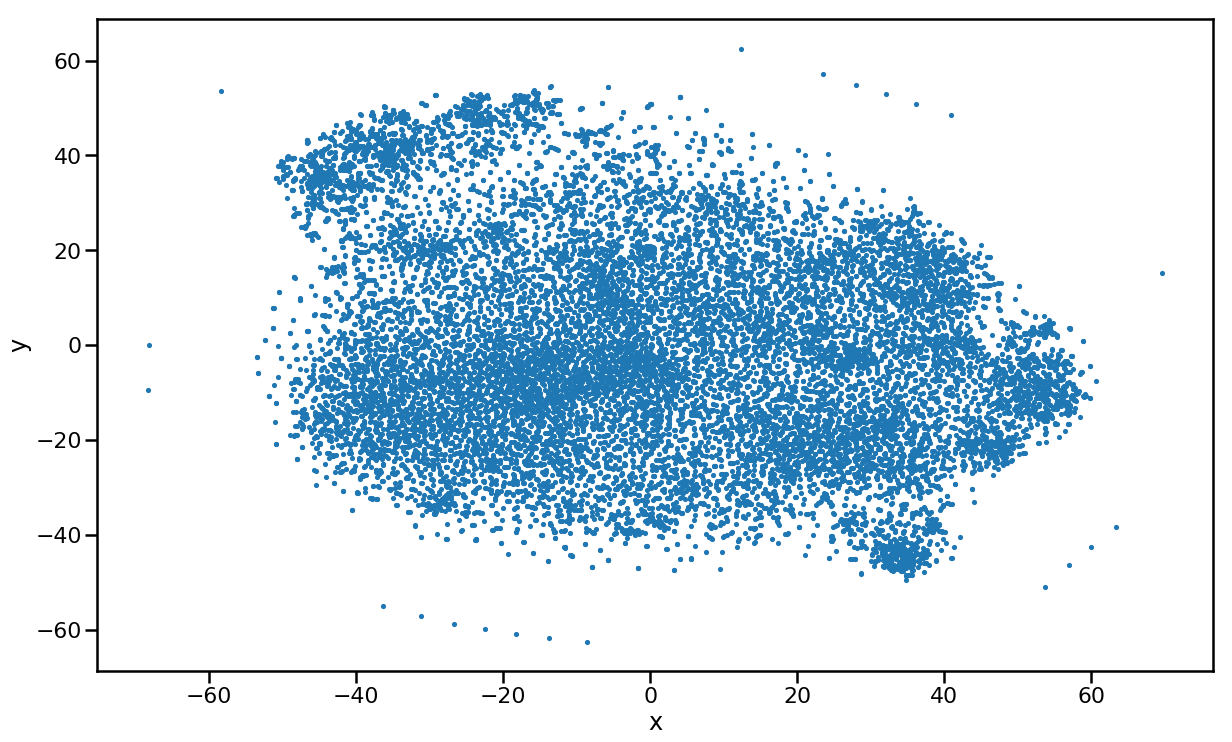

In [67]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [80]:
def plot_region(x_bounds, y_bounds):
    slice = points.loc[
        (points['x'] >= x_bounds[0]) &
        (points['x'] <= x_bounds[1]) &
        (points['y'] >= y_bounds[0]) &
        (points['y'] <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 10))
    for i, point in slice.iterrows():
        ax.text(point.x, point.y, point.word, fontsize=11)

**Function to print an area around a word**

In [ ]:
def plot_region_around_word(word):
    offset = 1.1
    word_point = points[points['word'] == word]
    point = word_point.values
    #Finding the coordinates of the given word and seeing the plot around that value
    plot_region([point[0][1]- offset, point[0][1] + offset], [point[0][2]- offset, point[0][2]+offset])

**The model clustered food items together**

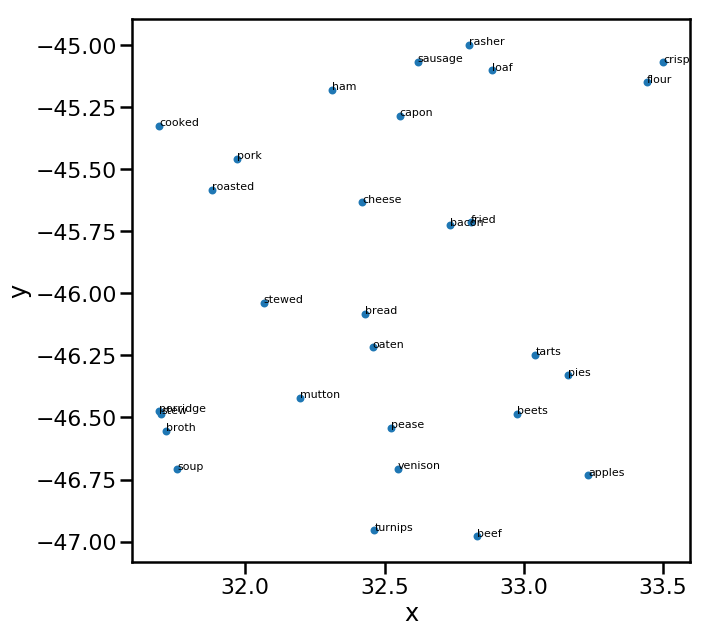

In [86]:
plot_region_around_word('bread')

### Explore semantic similarities between book characters

**Words closest to the given word**

In [70]:
thrones2vec.most_similar("Stark")

2019-01-31 18:35:52,750 : INFO : precomputing L2-norms of word weight vectors


[('Eddard', 0.6536884903907776),
 ('executed', 0.5517308712005615),
 ('absently', 0.5102276802062988),
 ('brotherly', 0.4766407907009125),
 ('saddened', 0.4758799076080322),
 ('Lyanna', 0.4734504222869873),
 ('divulge', 0.4692629873752594),
 ('Edrick', 0.4687919616699219),
 ('Knelt', 0.46866321563720703),
 ('Daryn', 0.46698540449142456)]

In [71]:
thrones2vec.most_similar("Aerys")

[('Jaehaerys', 0.6520094871520996),
 ('II', 0.6389628052711487),
 ('Conciliator', 0.6061580181121826),
 ('Maekar', 0.5874843597412109),
 ('Unlikely', 0.5867249965667725),
 ('appointment', 0.5863174200057983),
 ('Unworthy', 0.5843573212623596),
 ('Daeron', 0.5730962753295898),
 ('Mad', 0.5726089477539062),
 ('Defiance', 0.5708019733428955)]

In [72]:
thrones2vec.most_similar("Tyrion")

[('dwarf', 0.5159129500389099),
 ('Bronn', 0.45243000984191895),
 ('Shae', 0.44958972930908203),
 ('Griff', 0.43225517868995667),
 ('Halfmaester', 0.4251852035522461),
 ('irritation', 0.42478400468826294),
 ('crookedly', 0.4245011806488037),
 ('instantly', 0.42246213555336),
 ('wearily', 0.41833919286727905),
 ('exaggerated', 0.41293585300445557)]

**Linear relationships between word pairs**

In [73]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [74]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "Tyrion")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as dwarf is related to Tyrion


'dwarf'